# Parse Tracefiles to characterise variance
You must change the location of the script dir if you want to use relative paths to the trace.
Or , set the absolute path to the location of the directory containing the tracefiles.

In [26]:
import logging
import pandas as pd
import cx_Oracle
import matplotlib.pyplot as plt
import os
import re
import glob
#abspath = os.path.abspath(__file__)
#dname = os.path.dirname(abspath)
#os.chdir(f"{dname}/")
os.chdir("C:\\Users\\David Olivari\\Documents\\ONGOING DB WORK\\carsprd\\tracefiles_stuff\\bin")
trcs = glob.glob('../*.trc')
re_sess= re.compile('^\*\*\* SESSION ID:\((\d+\.\d+)\) (.+)$')
re_systime=re.compile('^.+tim=*([0-9]+) .+')

## parse the file
convert durations to secs 
note how variables are initialised in the for loop

In [27]:
columns = ['filename','SessIdentifier' , 'sess_start' , 'sys_tm_max' , 'sys_tm_min', 'duration_secs']
sessions_list=[]
for trace in trcs:
    with open(trace ) as f:
        min_sys_ts=999999999999999999
        max_sys_ts=0
        for line in f:
            sess_detail = re_sess.match(line)
            sys_ts = re_systime.match(line)
            if sess_detail:
                sess_tuple = sess_detail.groups(0)
            if sys_ts:
                t = int(sys_ts.groups(0)[0])
                if  min_sys_ts > t:
                    min_sys_ts = t
                else:
                    # may seem unnecessary, but tm doesn't have to be in order
                    # e.g.loops
                    if max_sys_ts < t:
                        max_sys_ts = t
                    
        duration = (max_sys_ts - min_sys_ts)/1000000
        complete_tuple = tuple([os.path.basename(trace)]) + sess_tuple + (max_sys_ts,min_sys_ts,duration)
        sessions_list.append(complete_tuple) 
sessions_df =pd.DataFrame(sessions_list,columns = columns)

In [28]:
sessions_df.describe()

,sys_tm_max,sys_tm_min,duration_secs
count,6.200000e+01,6.200000e+01,62.000000
mean,1.626103e+15,1.626103e+15,2.229786
std,9.327814e+09,9.328034e+09,2.097905
min,1.626091e+15,1.626090e+15,0.646564
25%,1.626094e+15,1.626094e+15,1.343379
50%,1.626102e+15,1.626102e+15,1.777895
75%,1.626112e+15,1.626112e+15,2.112691
max,1.626118e+15,1.626118e+15,15.648147


In [29]:
sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   filename        62 non-null     object 
 1   SessIdentifier  62 non-null     object 
 2   sess_start      62 non-null     object 
 3   sys_tm_max      62 non-null     int64  
 4   sys_tm_min      62 non-null     int64  
 5   duration_secs   62 non-null     float64
dtypes: float64(1), int64(2), object(3)
memory usage: 2.2+ KB


In [30]:
sessions_df.head(2)

,filename,SessIdentifier,sess_start,sys_tm_max,sys_tm_min,duration_secs
0,CARSPRD1_ora_1008.trc,2011.45273,2021-07-12 14:24:33.952,1626096275412068,1626096273952636,1.459432
1,CARSPRD1_ora_1129.trc,2154.37715,2021-07-12 18:16:16.408,1626110178374715,1626110176408339,1.966376


In [31]:
sessions_df['sess_start']=pd.to_datetime(sessions_df['sess_start'],errors='ignore')

In [32]:
sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   filename        62 non-null     object        
 1   SessIdentifier  62 non-null     object        
 2   sess_start      62 non-null     datetime64[ns]
 3   sys_tm_max      62 non-null     int64         
 4   sys_tm_min      62 non-null     int64         
 5   duration_secs   62 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 2.5+ KB


In [33]:
sessions_df.set_index('sess_start',inplace=True)

In [34]:
sessions_df.sort_index(inplace=True)


In [35]:
sessions_df

,filename,SessIdentifier,sys_tm_max,sys_tm_min,duration_secs
sess_start,,,,,
2021-07-12 12:48:17.752,CARSPRD1_ora_74156.trc,1454.7617,1626090503499640,1626090497753748,5.745892
2021-07-12 12:50:36.438,CARSPRD1_ora_77344.trc,1194.41835,1626090638335926,1626090636439340,1.896586
2021-07-12 12:51:21.752,CARSPRD1_ora_78787.trc,1399.50341,1626090683638620,1626090681752682,1.885938
2021-07-12 12:53:33.300,CARSPRD1_ora_81070.trc,401.4253,1626090814320725,1626090813300723,1.020002
2021-07-12 12:55:14.309,CARSPRD1_ora_83199.trc,21.7667,1626090916087402,1626090914309375,1.778027
...,...,...,...,...,...
2021-07-12 19:48:57.158,CARSPRD1_ora_18387.trc,1643.56241,1626115738395299,1626115737157839,1.237460
2021-07-12 19:52:56.784,CARSPRD1_ora_23344.trc,1815.5595,1626115978652648,1626115976784738,1.867910
2021-07-12 20:02:44.374,CARSPRD1_ora_37860.trc,420.12555,1626116566277014,1626116564374751,1.902263


## Scatter plot sessions vs duration

<AxesSubplot:xlabel='sess_start', ylabel='duration_secs'>

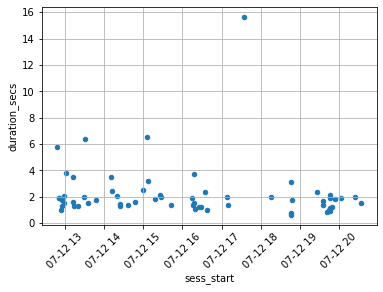

In [36]:

sessions_df.reset_index().plot.scatter(x = 'sess_start', 
                                       y = 'duration_secs',
                                       grid =True,
                                       rot=45
                                      )

## Sorted Data set by duration (descending)

In [37]:
sessions_df.sort_values(['duration_secs'],ascending=False)

,filename,SessIdentifier,sys_tm_max,sys_tm_min,duration_secs
sess_start,,,,,
2021-07-12 17:33:51.151,CARSPRD1_ora_49119.trc,1924.24337,1626107646799708,1626107631151561,15.648147
2021-07-12 15:05:55.847,CARSPRD1_ora_61667.trc,493.26433,1626098762369990,1626098755848591,6.521399
2021-07-12 13:30:33.729,CARSPRD1_ora_28965.trc,613.37751,1626093040085278,1626093033729347,6.355931
2021-07-12 12:48:17.752,CARSPRD1_ora_74156.trc,1454.7617,1626090503499640,1626090497753748,5.745892
2021-07-12 13:01:55.739,CARSPRD1_ora_93050.trc,486.23061,1626091319537230,1626091315740511,3.796719
...,...,...,...,...,...
2021-07-12 19:44:00.027,CARSPRD1_ora_12801.trc,2190.46825,1626115440995112,1626115440026670,0.968442
2021-07-12 19:46:04.578,CARSPRD1_ora_15956.trc,613.41467,1626115565485243,1626115564577903,0.907340
2021-07-12 19:40:49.437,CARSPRD1_ora_9380.trc,1951.29975,1626115250303870,1626115249436834,0.867036


## Seaborn visual WIP

<AxesSubplot:xlabel='sess_start', ylabel='duration_secs'>

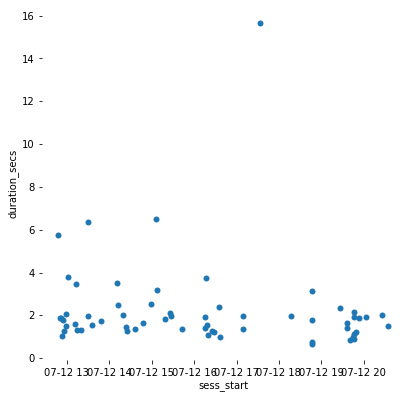

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="sess_start", y="duration_secs",
                #hue="clarity", size="depth",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=sessions_df.reset_index(), ax=ax)